In [1]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neighbors as skn
from sklearn.exceptions import ConvergenceWarning
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
from rvae import VAE
from rvae import train_model
from adapt.feature_based import CORAL
from adapt.instance_based import KMM
from adapt.feature_based import SA
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [4]:
# Augment with CHH data
X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
    Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
X_all_c = X_all_c[:,0:4,:]
lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
subsc = subject_id_corr

Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

In [5]:
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,NaN
1,1.0,62.26%,NaN,53,20,40,15,7,NaN
2,2.0,75.00%,NaN,32,8,26,17,10,NaN
3,3.0,51.72%,NaN,58,28,52,18,20,NaN
4,4.0,22.58%,NaN,62,48,61,36,28,NaN
5,5.0,55.88%,NaN,34,15,44,29,22,NaN
6,6.0,75.44%,NaN,57,14,55,32,16,NaN
7,7.0,84.00%,NaN,100,16,68,12,NaN,NaN
8,8.0,41.86%,NaN,43,25,48,26,26,NaN
9,9.0,72.58%,NaN,62,17,56,25,11,NaN


In [6]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
alphas = np.logspace(-5,-3,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []

In [9]:
Js = []
err_var = np.zeros_like(per_change)
r = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    idy = y_train[y_train<=0.3]
    
    # Cross validation
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off,False,False,False)
    cvn = len(X0_ss0-1)
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      sel = skf.SelectKBest(skf.r_regression,k=2925)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      kappa.append(np.linalg.cond(X0_ss0))
      X_test_ss = X_test_sst
      dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=1)

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=-1,normalize=False,eps=0.1)
      lasso = SA(
        estimator=lasso,
        Xt=X_test_ss,
        random_state=0
        )
      est_ls = lasso.fit(X0_ss,y_train)
    # Reconstruct nearest neighbor
    r[j] = est_ls.predict(X0_ss[y_n,:])
    err_var[j] = np.mean(abs(est_ls.predict(X0_ss)-y_train))
    rerror[j] = np.abs(r[j]-y_train[y_n])
    #s.append(est_ls.score(X0_ss,y_train))
    results_ls[j] = est_ls.predict(X_test_ss)
    # # # If reconstruction error is too high, use nearest neighbor
    # if rerror[j] > 0.1 and dx > 36:
    #     print('Using nearest neighbor')
    #     results_ls[j] = y_train[y_n]
    print('Lasso predicts',str(np.round(results_ls[j],2)),
              'for case with',str(np.round(per_change[j],2)),
             # 'with regularization',str(est_ls.alpha_),
              'with reconstruction error',str(np.round(rerror[j],9)),
              'maximum error',str(np.round(err_var[j],9)),
              'and neighbor',str(np.round(y_train[y_n],2).item()),
              'and distance',str((dx)))
    gerror[j] = (abs(results_ls[j]-y_test))
        

  


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.72 with reconstruction error 0.210447617 maximum error 0.166578296 and neighbor 0.81 and distance [44.98471677]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.47 with reconstruction error 0.361729576 maximum error 0.17173306 and neighbor 0.1 and distance [45.48707058]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.69 with reconstruction error 0.086237099 maximum error 0.174959461 and neighbor 0.48 and distance [58.56428652]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.42 with reconstruction error 0.050866105 maximum error 0.166247613 and neighbor 0.49 and distance [147.71813331]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.15 with reconstruction error 0.114040702 maximum error 0.164780804 and neighbor 0.47 and distance [57.07285432]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.44 with reconstruction error 0.237807567 maximum error 0.17377888 and neighbor 0.81 and distance [46.43322022]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.56 for case with 0.88 with reconstruction error 0.051589439 maximum error 0.17962465 and neighbor 0.44 and distance [60.57776232]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.4 with reconstruction error 0.154600192 maximum error 0.172363772 and neighbor 0.81 and distance [45.85704547]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.6 with reconstruction error 0.154372659 maximum error 0.196085297 and neighbor 0.31 and distance [49.27387714]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.56 for case with 0.81 with reconstruction error 0.408331423 maximum error 0.16364484 and neighbor 0.1 and distance [41.49455534]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.64 with reconstruction error 0.154728497 maximum error 0.168269576 and neighbor 0.72 and distance [51.48283374]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.72 with reconstruction error 0.114275997 maximum error 0.166086022 and neighbor 0.71 and distance [46.15621418]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.31 with reconstruction error 0.139732169 maximum error 0.169738628 and neighbor 0.44 and distance [47.59145464]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.68 with reconstruction error 0.24451322 maximum error 0.17519786 and neighbor 0.81 and distance [46.80707252]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.34 with reconstruction error 0.21429127 maximum error 0.167517259 and neighbor 0.47 and distance [61.4095908]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.59 with reconstruction error 0.175186963 maximum error 0.177463655 and neighbor 0.4 and distance [52.50013853]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.56 for case with 0.94 with reconstruction error 0.10060661 maximum error 0.16550502 and neighbor 0.44 and distance [54.31814942]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.56 for case with 0.84 with reconstruction error 0.433130512 maximum error 0.183070699 and neighbor 0.94 and distance [57.15599975]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.1 with reconstruction error 0.228312503 maximum error 0.16322881 and neighbor 0.81 and distance [44.19774921]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.41 with reconstruction error 0.247755009 maximum error 0.16606715 and neighbor 0.81 and distance [53.84604616]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.57 with reconstruction error 0.404763876 maximum error 0.187505006 and neighbor 0.28 and distance [80.34107072]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.66 with reconstruction error 0.019574561 maximum error 0.175796929 and neighbor 0.59 and distance [66.45054276]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.63 with reconstruction error 0.110073583 maximum error 0.171035262 and neighbor 0.48 and distance [59.12973572]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.47 with reconstruction error 0.105053774 maximum error 0.17476628 and neighbor 0.47 and distance [52.67978975]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.28 with reconstruction error 0.059292574 maximum error 0.168986808 and neighbor 0.64 and distance [73.85703926]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.59 with reconstruction error 0.237016316 maximum error 0.177298188 and neighbor 0.33 and distance [56.27800686]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.53 with reconstruction error 0.041987591 maximum error 0.206326519 and neighbor 0.6 and distance [53.50221506]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.56 for case with 0.86 with reconstruction error 0.24952614 maximum error 0.170741931 and neighbor 0.81 and distance [56.26713385]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.48 with reconstruction error 0.201750374 maximum error 0.16798723 and neighbor 0.33 and distance [49.07167776]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.66 with reconstruction error 0.214407502 maximum error 0.191296279 and neighbor 0.64 and distance [61.71173466]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.33 with reconstruction error 0.131885507 maximum error 0.168092867 and neighbor 0.48 and distance [56.60285642]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.49 with reconstruction error 0.221252452 maximum error 0.171809161 and neighbor 0.86 and distance [64.43505468]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.78 with reconstruction error 0.104677653 maximum error 0.174908616 and neighbor 0.69 and distance [114.15280656]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.56 for case with 0.81 with reconstruction error 0.095708515 maximum error 0.172061624 and neighbor 0.47 and distance [46.22081782]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.57 for case with 0.71 with reconstruction error 0.181468378 maximum error 0.167682851 and neighbor 0.72 and distance [45.66432306]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.58 for case with 0.32 with reconstruction error 0.221724986 maximum error 0.165669599 and neighbor 0.41 and distance [62.54761085]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


Fit transform...
Fit Estimator...
Lasso predicts 0.56 for case with 0.83 with reconstruction error 0.248772479 maximum error 0.171411852 and neighbor 0.81 and distance [48.81074365]


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


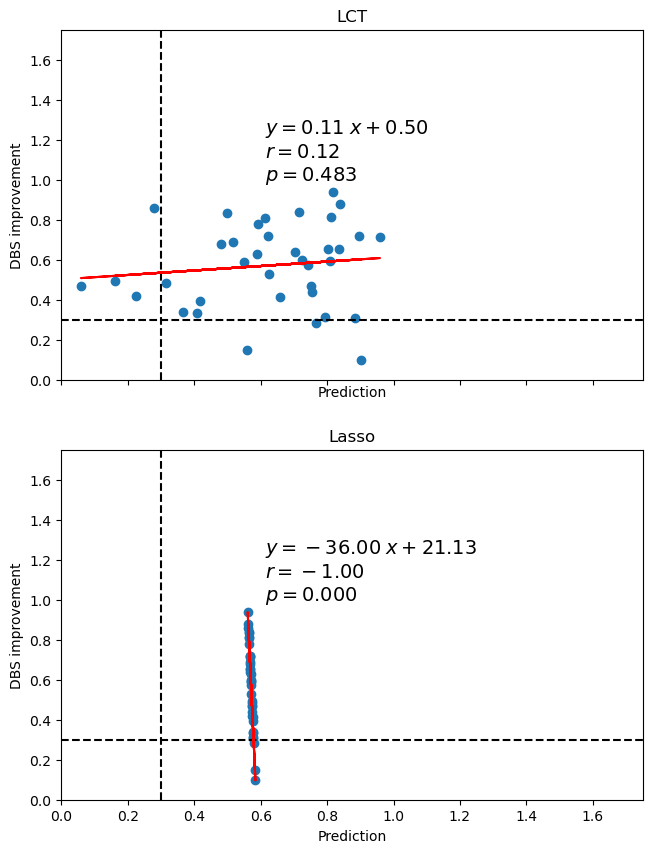

In [10]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,1.75])
plt.xlim([0,1.75])
plt.style.use('default')